In [1]:
import omnipath as op
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pySankey import sankey as sn

sns.set(rc={'figure.figsize':(6,4)})

/users/pravicha/.conda/envs/vs_stitcher/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
###--------------------------------------------LOAD DATA
db = op.interactions.import_intercell_network(transmitter_params = {"categories":"ligand"}, receiver_params = {"categories": "receptor"})
db = db[np.logical_not(db['genesymbol_intercell_source'].str.startswith('HLA'))]
db = db[np.logical_not(db['genesymbol_intercell_target'].str.startswith('HLA'))]
tgts = pd.read_csv('/dcs04/lieber/marmaypag/spatialNac_LIBD4125/spatial_NAc/processed-data/22_gene_risk_LR_analysis/02-OpenTarget_risk_genes/Substance_dependence_risk_genes_01thr_hot1.csv')
tgts['gene']=tgts['genes']
tgts = tgts.drop(columns=['genes']).set_index(['gene'])

In [3]:
###--------------------------------------------DEFINE FUNCTIONS
def find_hits(target, db):                                                                      #Function for identifying genes that are targets or receptors (tgts) within a given database (db)
    hits = db['genesymbol_intercell_source'].isin(list(target.index))                           #Out of targets, which act as sources (aka: ligands)? 
    hits = hits.to_frame()
    hits['gene'] = list(db['genesymbol_intercell_source'])
    hits = hits[hits['genesymbol_intercell_source']==True]
    
    print("Source hits: ", len(hits['gene'].unique()))
    if (len(target.index.unique())>0):
        print("% of source hits in total genes of interest: ", len(hits['gene'].unique())/len(target.index.unique())*100)
        percSrc = len(hits['gene'].unique())/len(target.index.unique())
    else:
        percSrc = 0

    final_s = pd.merge(hits, db[['transmitter_intercell_source', 'receiver_intercell_source',
        'secreted_intercell_source',
        'plasma_membrane_transmembrane_intercell_source',
        'plasma_membrane_peripheral_intercell_source']], how="inner", left_index = True, right_index = True)
    final_s['source']=1
    final_s[['gene', 'source']]

    hits = db['genesymbol_intercell_target'].isin(list(target.index))
    hits = hits.to_frame()
    hits['gene'] = list(db['genesymbol_intercell_target'])
    hits = hits[hits['genesymbol_intercell_target']==True]
    
    print("Target hits: ", len(hits['gene'].unique()))
    if (len(target.index.unique())>0):
        print("% of target hits in total genes of interest: ", len(hits['gene'].unique())/len(target.index.unique())*100)
        percTgt = len(hits['gene'].unique())/len(target.index.unique())*100
    else:
        percTgt=0

    final_t = pd.merge(hits, db[['transmitter_intercell_target', 'receiver_intercell_target',
        'secreted_intercell_target',
        'plasma_membrane_transmembrane_intercell_target',
        'plasma_membrane_peripheral_intercell_target']], how="inner", left_index = True, right_index = True)
    final_t['target']=2
    final_t[['gene', 'target']]
    
    target['Empty'] = 0
    alltgt = target['Empty'].reset_index()
    alltgt.rename(columns = {'index':'gene'}, inplace = True)
    summary_LR = pd.merge(final_s[['gene', 'source','secreted_intercell_source',
       'plasma_membrane_transmembrane_intercell_source',
       'plasma_membrane_peripheral_intercell_source']], final_t[['gene', 'target', 'secreted_intercell_target',
       'plasma_membrane_transmembrane_intercell_target',
       'plasma_membrane_peripheral_intercell_target']], how="outer", on=['gene','gene']).fillna(0)
    summary_LR = pd.merge(summary_LR.drop_duplicates(subset = ["gene"]), alltgt, how="outer", on = ['gene','gene']).fillna(0)
    summary_LR['source+target']=summary_LR['source']+summary_LR['target']
    summary_LR['source+target'].astype("category")
    summary_LR['source+target'].replace({
    0.0: 'None', 
    1.0: 'Source', 
    2.0: 'Target', 
    3.0: 'Source+Target'}, inplace = True)
    
    return(final_s, percSrc, final_t, percTgt, summary_LR.drop_duplicates(subset = ["gene"]))           #Return final sources, targets, corresponding percentegages and a 
                                                                                                        #summary ligand-receptor table including information of molecule type
                                                                                                        
def typeOfMolecule(summary_LR, disease):                                                                # Function for identifying the types of receptors (solluble, membrane expressed) flagged in find_hits function
    summary_LR[['secreted_intercell_source',
              'plasma_membrane_transmembrane_intercell_source',
              'plasma_membrane_peripheral_intercell_source',
              'secreted_intercell_target',
              'plasma_membrane_transmembrane_intercell_target',
              'plasma_membrane_peripheral_intercell_target']] = summary_LR[['secreted_intercell_source',
              'plasma_membrane_transmembrane_intercell_source',
              'plasma_membrane_peripheral_intercell_source',
              'secreted_intercell_target',
              'plasma_membrane_transmembrane_intercell_target',
              'plasma_membrane_peripheral_intercell_target']].astype(int)

    source_only = summary_LR[summary_LR['source+target']=='Source']
    source_tp = np.asarray([np.shape(source_only[source_only['secreted_intercell_source']==1])[0], 
              np.shape(source_only[source_only['plasma_membrane_transmembrane_intercell_source']==1])[0], 
              np.shape(source_only[source_only['plasma_membrane_peripheral_intercell_source']==1])[0]]).reshape(-1,1)

    target_only = summary_LR[summary_LR['source+target']=='Target']
    target_tp = np.asarray([
              np.shape(target_only[target_only['secreted_intercell_target']==1])[0], 
              np.shape(target_only[target_only['plasma_membrane_transmembrane_intercell_target']==1])[0], 
              np.shape(target_only[target_only['plasma_membrane_peripheral_intercell_target']==1])[0]]).reshape(-1,1)

    source_and_target = summary_LR[summary_LR['source+target']=='Source+Target']
    source_and_target_tp = np.asarray([np.shape(source_and_target[source_and_target['secreted_intercell_source']==1])[0], 
              np.shape(source_and_target[source_and_target['plasma_membrane_transmembrane_intercell_source']==1])[0], 
              np.shape(source_and_target[source_and_target['plasma_membrane_peripheral_intercell_source']==1])[0]]).reshape(-1,1)


    typemol = pd.DataFrame(np.concatenate((source_tp, target_tp, source_and_target_tp), axis = 1), 
                     index = ['source', 'target', 'source+target'], 
                     columns = ['secreted', 'transmembrane', 'peripheral'])

    typemol.transpose().plot(kind="bar", stacked=True, cmap = 'Dark2')
    plt.title("Types of Ligands and Receptors in %s" % disease)
    plt.savefig("/dcs04/lieber/marmaypag/spatialNac_LIBD4125/spatial_NAc/plots/22_gene_risk_LR_analysis/04-Disease_LRs/Ls_Rs_in_%s.png" % disease, dpi = 300, bbox_inches='tight', transparent=True)
    plt.show()

    return(typemol)

def topocurring(targets, hits):                                                                 #Function for identifying top occuring genes in a set of groups (e.g.: diseases, databases)
    top10S = targets.loc[list(hits['gene'].unique())].sum(axis = 1).sort_values(ascending = False).to_frame(name = 'Occurances')
    top10S['Diseases'] = 'A'
    for n in range (0, len(list(top10S.index))):
        info = targets.loc[top10S.index[n]]
        info = info[info>0].to_frame()
        l = []
        for i in range (0,len(info.index)):
            l.append(info.index[i].split("_")[0])
        top10S['Diseases'][n] = ", ".join(np.unique(l))
    return top10S

Source hits:  12
% of source hits in total genes of interest:  7.792207792207792
Target hits:  18
% of target hits in total genes of interest:  11.688311688311687
Source hits:  12
% of source hits in total genes of interest:  7.792207792207792
Target hits:  18
% of target hits in total genes of interest:  11.688311688311687


/tmp/ipykernel_3634869/4017279996.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  summary_LR['source+target'].replace({
/tmp/ipykernel_3634869/4017279996.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

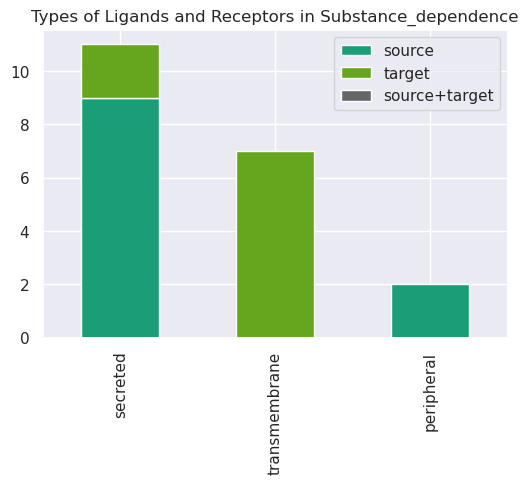

/tmp/ipykernel_3634869/4017279996.py:111: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  top10S['Diseases'][n] = ", ".join(np.unique(l))
/tmp/ipykernel_3634869/4017279996.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [4]:
###--------------------------------------------RUN ANALYSIS
# Overall LR incidence in SCZ risk genes and molecule characterisation
all_source, pctsrc, all_targets, pcttgt, summary_LR = find_hits(tgts,db)
source, percSrc, targets, percTgt, summol = find_hits(tgts, db)
type_of_molecule = typeOfMolecule(summol, 'Substance_dependence')
all_disease = summol['source+target'].rename('Substance_dependence').value_counts().to_frame()
disease_summary = summol
top_S = topocurring(tgts, all_source)
top_T = topocurring(tgts, all_targets)

In [5]:
hits_all = list(top_T.index)+list(top_S.index)

print("total Substance dependence LR hits: ", len(list(top_T.index)+list(top_S.index)))
print("Substance dependence hits that act as both Ligand and Receptor", set([x for x in hits_all if hits_all.count(x) > 1]))

LRs_diseases = pd.read_csv('/dcs04/lieber/marmaypag/spatialNac_LIBD4125/spatial_NAc/processed-data/22_gene_risk_LR_analysis/02-OpenTarget_risk_genes/Substance_dependence_risk_genes_01thr.csv', index_col=0)
LR_summary = LRs_diseases.loc[list(pd.concat([top_T,top_S]).index.unique())]

# Determine interactions where both L and R are implicated in SCZ
    # Sum associations of interactions for combined association
top_pairs = db[['genesymbol_intercell_source','genesymbol_intercell_target']][(db['genesymbol_intercell_source'].isin(list(summol.gene))) & (db['genesymbol_intercell_target'].isin(list(summol.gene)))]
top_pairs

total Substance dependence LR hits:  30
Substance dependence hits that act as both Ligand and Receptor {'WNT5A', 'DPP4'}


,genesymbol_intercell_source,genesymbol_intercell_target
9990,BDNF,CTNND1


In [6]:
if(top_pairs.shape[0] > 0):
    top_pairs['Combined_association'] = 0.0

    for n in range(0,np.shape(top_pairs)[0]):
        tmp=0.0
        if top_pairs.iloc[n][0] in list(LR_summary.index):
            tmp += LR_summary.loc[top_pairs.iloc[n][0]]['genetic_association']

        if top_pairs.iloc[n][1] in list(LR_summary.index):
            tmp += LR_summary.loc[top_pairs.iloc[n][1]]['genetic_association']
        top_pairs['Combined_association'].iloc[n] += tmp
        
    top_pairs.sort_values(by='Combined_association', ascending = False)

    # Visualise interactions where both L and R are implicated in disease with Sankey plot
    subset = top_pairs[['genesymbol_intercell_source','genesymbol_intercell_target']]
    if(subset.shape[0] > 1):
        sn.sankey(subset['genesymbol_intercell_source'], subset['genesymbol_intercell_target'], fontsize = 10)
        fig = plt.gcf()
        fig.set_size_inches(6, 14)
        plt.title("Interactions with two Substance dependence risk targets" )
        plt.savefig("/dcs04/lieber/marmaypag/spatialNac_LIBD4125/spatial_NAc/plots/22_gene_risk_LR_analysis/04-Disease_LRs/interactions_Substance_dependence_tgts.pdf", dpi=300, bbox_inches='tight')
        plt.show()

    subset.to_csv('/dcs04/lieber/marmaypag/spatialNac_LIBD4125/spatial_NAc/processed-data/22_gene_risk_LR_analysis/04-Disease_LRs/Substance_dependence_top_interactions.csv', index = False)

secondary = db[['genesymbol_intercell_source','genesymbol_intercell_target']][(db['genesymbol_intercell_source'].isin(list(summol.gene))) | (db['genesymbol_intercell_target'].isin(list(summol.gene)))]
secondary.to_csv('/dcs04/lieber/marmaypag/spatialNac_LIBD4125/spatial_NAc/processed-data/22_gene_risk_LR_analysis/04-Disease_LRs/Substance_dependence_LorR_interactions.csv', index = False)

/tmp/ipykernel_3634869/2817771577.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if top_pairs.iloc[n][0] in list(LR_summary.index):
/tmp/ipykernel_3634869/2817771577.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tmp += LR_summary.loc[top_pairs.iloc[n][0]]['genetic_association']
/tmp/ipykernel_3634869/2817771577.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if top_pairs.iloc[n][1] in list(LR_summary.index):
/tmp/ipyk